# Midterm 2 Computer Work

In [1]:
'''
Packages Used
'''

import pandas as pd
import numpy as np

from pulp import *
import riskfolio as rp
import quadprog

import FinOpsCodeDeck as finops

import matplotlib.pyplot as plt

In [2]:
'''
given data
'''
annum_ret_a = pd.read_csv('Annual_Returns_AAA.csv',index_col='Year')
annum_ret_b = pd.read_csv('Annual_Returns_BBB.csv',index_col='Year')
annum_ret_a

,MSFT,GE,GM
Year,,,
1,0.51,0.58,0.31
2,1.11,0.39,2.22
3,0.62,0.77,0.78
4,0.78,1.19,-0.38
5,-0.76,1.07,1.43
6,0.59,1.13,1.02
7,0.57,0.42,-0.79
8,0.22,-1.44,2.39
9,0.62,0.71,-0.98


# Question 1

In [3]:
'''
Question 1 part b
'''
M = np.array([[1,-1,0],[-1,4,-2],[0,-2,3]])
finops.positive_semi_definite(M)

The given matrix is Positive Semi Definite


# Question 2

In [4]:
'''Question 2 part a'''
annum_ret_a['GE'].mean()

0.4383333333333333

In [5]:
'''question 2 part b'''
annum_ret_a.cov()

,MSFT,GE,GM
MSFT,0.300324,-0.036070,-0.074314
GE,-0.036070,0.659597,-0.249086
GM,-0.074314,-0.249086,1.202766


In [6]:
'''Quesion 2 part c'''
finops.positive_semi_definite(annum_ret_a[['MSFT','GM']].cov())  # Function checks Eigen values

The given matrix is Positive Semi Definite


# Question 3

In [7]:
'''question 3 part a'''
alloc_diverse = np.array([0.33,0.33,0.34])
alloc_risky = np.array([0,0,1])

mu_diverse = sum(annum_ret_a.mean().to_numpy() * alloc_diverse)
mu_risky = sum(annum_ret_a.mean().to_numpy() * alloc_risky)
print(mu_diverse, mu_risky)

sigma_diverse = np.matmul(np.matmul(alloc_diverse,annum_ret_a.cov().to_numpy()), alloc_diverse)
sigma_risky = np.matmul(np.matmul(alloc_risky,annum_ret_a.cov().to_numpy()), alloc_risky)
print(sigma_diverse, sigma_risky)

0.54745 0.7074999999999999
0.16314821909090915 1.202765909090909


# Question 5

In [8]:
'''Constraint matrix'''
A = np.zeros((3,3))
np.fill_diagonal(A,1)
C=np.concatenate((np.ones((1,3)),A,np.reshape(annum_ret_a.mean().to_numpy(),(1,3))))

'''Right side'''
b=np.zeros(5)
b[0]=1

'''REQUIRED RETURN HERE'''
b[-1] = 0

Text(0, 0.5, 'Required Return')

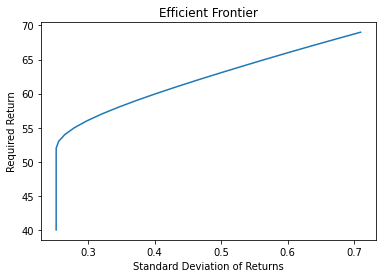

In [9]:
req_returns = range(40,70,1)
variance = []
sharpe = []
for req_return in req_returns:
    '''Non-Negativity (0s along main diaganol'''
    A = np.zeros((3,3))
    np.fill_diagonal(A,1)
    '''Adding in the weighting to 1'''
    C=np.concatenate((np.ones((1,3)),A,np.reshape(annum_ret_a.mean().to_numpy(),(1,3))))
    '''Equality vector - first is equal to 1, last 20 are greater than 0'''
    b=np.zeros(5)
    b[0]=1
    b[-1]=req_return/100
    alloc, min_var = quadprog.solve_qp(G=annum_ret_a.cov().to_numpy(),a=np.zeros(3),C=np.transpose(C),b=b,meq=1)[:2]
    variance.append(min_var)
    sharpe.append((req_return/100) / np.sqrt(min_var))

plt.plot(np.sqrt(variance),req_returns)
plt.title('Efficient Frontier')
plt.xlabel('Standard Deviation of Returns')
plt.ylabel('Required Return')

Text(0, 0.5, 'Sharpe Ratio')

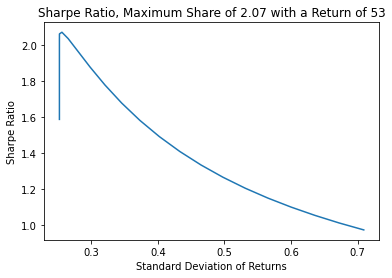

In [10]:
pd.options.display.float_format = '{:.2f}'.format
sharpe_df = pd.DataFrame(data=sharpe, index=req_returns, columns=['sharpe'])
max_sharpe_ret = sharpe_df.idxmax()

plt.plot(np.sqrt(variance),sharpe)
plt.title('Sharpe Ratio, Maximum Share of {:.2f} with a Return of {:.0f}'.format(sharpe_df.max()[0], max_sharpe_ret[0]))
plt.xlabel('Standard Deviation of Returns')
plt.ylabel('Sharpe Ratio')

In [11]:
'''Non-Negativity (0s along main diaganol'''
A = np.zeros((3,3))
np.fill_diagonal(A,1)
'''Adding in the weighting to 1'''
C=np.concatenate((np.ones((1,3)),A,np.reshape(annum_ret_a.mean().to_numpy(),(1,3))))
'''Equality vector - first is equal to 1, last 20 are greater than 0'''
b=np.zeros(5)
b[0]=1
b[-1]=53/100
alloc, min_var = quadprog.solve_qp(G=annum_ret_a.cov().to_numpy(),a=np.zeros(3),C=np.transpose(C),b=b,meq=1)[:2]
alloc

array([0.48534556, 0.27026471, 0.24438973])

In [12]:
sum(alloc * annum_ret_a.mean())

0.5299999999999999

# Question 6

In [13]:
mu_0 = annum_ret_a.mean().mean()
port = rp.Portfolio(returns=annum_ret_a, lowerret=mu_0)
port.assets_stats(method_mu='hist',method_cov='hist')
w = port.optimization(model='Classic', rm='MAD', obj='MinRisk',rf=0,hist=True,l=0)
w

,weights
MSFT,0.51
GE,0.19
GM,0.30


In [14]:
sum(w.to_numpy().squeeze() * annum_ret_a.mean().to_numpy())

0.5458333332998343